<a href="https://colab.research.google.com/github/davechang-99/Dementia-AI/blob/main/dementia_pre_detaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

환경 설정 및 런타임 재시작

In [ ]:
# ViT 오류 방지를 위한 transformers 버전 고정 및 torch, numpy, librosa 등 주요 패키지의 호환 버전 재설치 후 런타임 재시작
!pip install transformers==4.40.1
!pip uninstall -y numpy matplotlib torch torchvision torchaudio librosa > /dev/null
!pip install numpy==1.26.4 matplotlib==3.8.0 librosa==0.10.1 --quiet
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118 --quiet
import os
os.kill(os.getpid(), 9)

# 설치된 패키지 버전 확인
import numpy, torch, torchvision, librosa
print("✅ numpy:", numpy.__version__)
print("✅ torch:", torch.__version__)
print("✅ torchvision:", torchvision.__version__)
print("✅ librosa:", librosa.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

GPU/CPU 장치 설정

In [1]:
# PyTorch를 이용하여 CUDA가 가능한 경우 GPU, 아니면 CPU 장치를 자동으로 선택하여 연산 환경 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[DEVICE] Using device: {device}")

[DEVICE] Using device: cuda


Google Drive 마운트 및 데이터셋 경로 설정

In [2]:
# ✅ Google Drive 마운트
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

# ✅ 데이터셋 경로 설정
dataset_path = Path("/content/drive/MyDrive/DATASET_A")
print("📂 데이터셋 위치:", dataset_path)

Mounted at /content/drive
📂 데이터셋 위치: /content/drive/MyDrive/DATASET_A


폴더 구조 출력 함수

In [3]:
# ✅ 하위 폴더 구조만 출력하는 함수 정의
def print_folder_tree(path: Path, indent: str = ""):
    if path.is_dir():
        print(f"{indent}📁 {path.name}/")
        for child in sorted(path.iterdir()):
            if child.is_dir():
                print_folder_tree(child, indent + "    ")

# ✅ 폴더 구조 출력
print("✅ 폴더 구조만 출력:")
print_folder_tree(dataset_path)

✅ 폴더 구조만 출력:
📁 DATASET_A/
    📁 Dementia/
        📁 train/
        📁 val/
    📁 Normal/
        📁 train/
        📁 val/


 DATASET_A 내 중복 파일 확인 및 삭제

In [10]:
import os
from pathlib import Path

# ✅ DATASET_A 내 중복 파일 확인 및 삭제
def find_and_remove_duplicates(base_dir):
    """
    DATASET_A의 훈련/검증 데이터 간에 중복된 파일을 찾아 삭제합니다.
    """
    train_normal_path = Path(base_dir) / "Normal" / "train"
    train_dementia_path = Path(base_dir) / "Dementia" / "train"
    val_normal_path = Path(base_dir) / "Normal" / "val"
    val_dementia_path = Path(base_dir) / "Dementia" / "val"

    # 훈련 데이터셋의 파일 이름들
    train_files = {p.name for p in train_normal_path.glob("*.wav")}
    train_files.update({p.name for p in train_dementia_path.glob("*.wav")})

    # 검증 데이터셋의 파일 이름들
    val_files = {p.name for p in val_normal_path.glob("*.wav")}
    val_files.update({p.name for p in val_dementia_path.glob("*.wav")})

    # 중복 파일 찾기
    overlap = train_files.intersection(val_files)

    if len(overlap) > 0:
        print(f"❌ 경고: 원본 DATASET_A 훈련/검증 데이터에 중복 파일이 {len(overlap)}개 발견되었습니다.")
        print(f"중복 파일 예시: {list(overlap)[:5]}")

        # 중복 파일 삭제 (검증 데이터셋에서만 삭제)
        # 훈련 데이터셋은 남겨두고, 검증 데이터셋에 있는 중복 파일을 삭제하여 데이터 분리를 명확히 합니다.
        deleted_count = 0
        for file_name in overlap:
            # val/Normal 폴더에서 파일 찾기
            file_to_delete = val_normal_path / file_name
            if file_to_delete.exists():
                os.remove(file_to_delete)
                deleted_count += 1
                continue

            # val/Dementia 폴더에서 파일 찾기
            file_to_delete = val_dementia_path / file_name
            if file_to_delete.exists():
                os.remove(file_to_delete)
                deleted_count += 1

        print(f"✅ 검증 데이터셋에서 중복 파일 {deleted_count}개를 삭제했습니다.")
    else:
        print("✅ 원본 DATASET_A 훈련/검증 데이터 간 중복 파일이 없습니다. (삭제 작업 필요 없음)")

# DATASET_A 경로 설정
dataset_a_path = Path("/content/drive/MyDrive/DATASET_A")
find_and_remove_duplicates(dataset_a_path)

❌ 경고: 원본 DATASET_A 훈련/검증 데이터에 중복 파일이 109개 발견되었습니다.
중복 파일 예시: ['노인남여_노인대화08_F_1531552733_69_수도권_실내_10060.wav', '노인남여_노인대화08_F_1531552733_69_수도권_실내_P02112.wav', '노인남여_노인대화08_F_1531552733_69_수도권_실내_10059.wav', '노인남여_노인대화08_F_1531552733_69_수도권_실내_10040.wav', '노인남여_노인대화07_F_1526682663_63_수도권_실내_08606.wav']
✅ 검증 데이터셋에서 중복 파일 109개를 삭제했습니다.


Mel-spectrogram 이미지 변환 및 저장

In [ ]:
# ✅ 라이브러리 불러오기
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
import os

# ✅ 원본 음성 데이터 경로
dataset_path = Path("/content/drive/MyDrive/DATASET_A")

# ✅ Mel-spectrogram 저장 경로
mel_output_dir = Path("/content/MEL_DATASET")

# ✅ 클래스 및 분할 리스트
classes = ["Normal", "Dementia"]
splits = ["train", "val"]

# ✅ 동일한 폴더 구조 생성
for cls in classes:
    for split in splits:
        target_dir = mel_output_dir / cls / split
        target_dir.mkdir(parents=True, exist_ok=True)

# ✅ Mel-spectrogram 저장 함수 정의
def save_mel(wav_path, save_path):
    try:
        y, sr = librosa.load(wav_path, sr=16000)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        plt.figure(figsize=(2.24, 2.24), dpi=100)
        librosa.display.specshow(mel_db, sr=sr, cmap='viridis')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"❌ 에러 발생: {wav_path} → {e}")

# ✅ 변환 실행
for cls in classes:
    for split in splits:
        input_dir = dataset_path / cls / split
        output_dir = mel_output_dir / cls / split

        wav_files = sorted(input_dir.glob("*.wav"))
        print(f"🎧 변환 중: {cls}/{split} → 총 {len(wav_files)}개 파일")

        for wav_path in wav_files:
            output_path = output_dir / (wav_path.stem + ".png")
            save_mel(wav_path, output_path)

print("✅ 모든 Mel-spectrogram 이미지 저장 완료")

🎧 변환 중: Normal/train → 총 1204개 파일


셀 6: Dataset 클래스, 전처리 및 DataLoader 정의

In [5]:
# ✅ 라이브러리 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path

# ✅ 가우시안 노이즈 추가를 위한 커스텀 변환 클래스 정의
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# ✅ Mel-spectrogram 이미지 Dataset 클래스
class MelImageDataset(Dataset):
    def __init__(self, base_dir, split="train", transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.classes = ["Normal", "Dementia"]

        for label, cls in enumerate(self.classes):
            cls_path = Path(base_dir) / cls / split
            img_paths = sorted(cls_path.glob("*.png"))
            self.samples.extend(img_paths)
            self.labels.extend([label] * len(img_paths))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = Image.open(self.samples[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# ✅ 훈련용 이미지 전처리 (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=0.01)
])

# ✅ 검증용 이미지 전처리 (데이터 증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Dataset 및 DataLoader 정의
base_path = "/content/MEL_DATASET"
train_data = MelImageDataset(base_path, split="train", transform=train_transform)
val_data = MelImageDataset(base_path, split="val", transform=val_transform)

셀 7: CNN 및 ViT 모델 클래스 정의

In [6]:
# ✅ 라이브러리 임포트
import torch
import torch.nn as nn
from transformers import ViTModel, ViTImageProcessor

# CNN 모델 클래스 정의
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

# ViT 모델 클래스 정의
class ViTClassifier(nn.Module):
    # processor를 __init__에서 한 번만 초기화하여 효율성 개선
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.fc = nn.Linear(self.vit.config.hidden_size, 2)
        self.processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

    # forward 함수 내에서 프로세서를 재사용
    def forward(self, x):
        # 텐서 이미지를 PIL 이미지 리스트로 변환
        pil_images = [transforms.ToPILImage()(img.cpu()) for img in x]
        # 프로세서를 사용하여 입력 데이터 준비
        inputs = self.processor(images=pil_images, return_tensors="pt").to(x.device)
        outputs = self.vit(**inputs)
        return self.fc(outputs.last_hidden_state[:, 0])

셀 8: Adaboost용 데이터 로딩 함수

In [7]:
# ✅ 라이브러리 임포트
import numpy as np
from PIL import Image
from pathlib import Path
import os # os 라이브러리 추가

# Adaboost용 이미지 로딩 함수 (폴더 구조 반영)
def load_images_and_labels(base_dir, split="train", size=(64, 64)):
    X, y = [], []
    classes = ["Normal", "Dementia"]

    for label, cls in enumerate(classes):
        cls_path = Path(base_dir) / cls / split
        img_paths = sorted(cls_path.glob("*.png"))

        for path in img_paths:
            img = Image.open(path).convert("L").resize(size)
            X.append(np.array(img).flatten())
            y.append(label)

    return np.array(X), np.array(y)

# ✅ base_dir는 MEL_DATASET 폴더의 루트 경로
base_dir = "/content/MEL_DATASET"

# 훈련용 이미지 벡터 로딩
X_train, y_train = load_images_and_labels(base_dir, split="train")

# 검증용 이미지 벡터 로딩
X_val, y_val = load_images_and_labels(base_dir, split="val")

print(f"훈련 데이터 크기: {X_train.shape}, 레이블: {y_train.shape}")
print(f"검증 데이터 크기: {X_val.shape}, 레이블: {y_val.shape}")

# ✅ 데이터셋 중복 확인 코드 추가
train_filenames = {os.path.basename(p) for p in (Path(base_dir) / "Normal" / "train").glob("*.png")}
train_filenames.update({os.path.basename(p) for p in (Path(base_dir) / "Dementia" / "train").glob("*.png")})

val_filenames = {os.path.basename(p) for p in (Path(base_dir) / "Normal" / "val").glob("*.png")}
val_filenames.update({os.path.basename(p) for p in (Path(base_dir) / "Dementia" / "val").glob("*.png")})

# 교집합을 찾아 중복 파일 확인
overlap = train_filenames.intersection(val_filenames)

if len(overlap) > 0:
    print(f"\n❌ 경고: 훈련 데이터와 검증 데이터에 중복 파일이 {len(overlap)}개 발견되었습니다.")
    print(f"중복 파일 예시: {list(overlap)[:5]}")
    print("→ Adaboost 모델의 완벽한 성능은 이 중복 때문일 가능성이 높습니다.")
else:
    print("\n✅ 훈련 데이터와 검증 데이터 간에 중복 파일이 없습니다. Adaboost 모델의 성능을 재확인하세요.")

훈련 데이터 크기: (2484, 4096), 레이블: (2484,)
검증 데이터 크기: (724, 4096), 레이블: (724,)

❌ 경고: 훈련 데이터와 검증 데이터에 중복 파일이 109개 발견되었습니다.
중복 파일 예시: ['노인남여_노인대화08_F_1531552733_69_수도권_실내_10038.png', '노인남여_노인대화08_F_1531552733_69_수도권_실내_P02110.png', '노인남여_노인대화08_F_1531552733_69_수도권_실내_10063.png', '노인남여_노인대화08_F_1531552733_69_수도권_실내_10043.png', '노인남여_노인대화08_F_1531552733_69_수도권_실내_P02152.png']
→ Adaboost 모델의 완벽한 성능은 이 중복 때문일 가능성이 높습니다.


셀 9: 모델 학습(Adaboost) 및 최종 평가

셀 10: 모델 학습(Random Forest) 및 최종 평가

--- CNN 하이퍼파라미터 튜닝 시작 ---

[튜닝] LR: 0.001, 배치 크기: 16


100%|██████████| 5/5 [01:03<00:00, 12.60s/it]


✅ 검증 정확도: 100.00%

[튜닝] LR: 0.001, 배치 크기: 32


100%|██████████| 5/5 [01:01<00:00, 12.38s/it]


✅ 검증 정확도: 100.00%

[튜닝] LR: 0.0001, 배치 크기: 16


100%|██████████| 5/5 [01:03<00:00, 12.68s/it]


✅ 검증 정확도: 69.48%

[튜닝] LR: 0.0001, 배치 크기: 32


100%|██████████| 5/5 [01:01<00:00, 12.27s/it]


✅ 검증 정확도: 48.90%

--- 튜닝 결과 ---
✅ 최적 하이퍼파라미터: {'lr': 0.001, 'batch_size': 16}
✅ 최고 검증 정확도: 100.00%

--- 최적화된 하이퍼파라미터로 CNN 모델 학습 ---


100%|██████████| 10/10 [02:06<00:00, 12.62s/it]



--- ViT 모델 학습 ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

100%|██████████| 5/5 [03:54<00:00, 46.83s/it]



--- RandomForest 모델 학습 ---

--- RandomForest 모델 훈련 데이터 정확도: 100.00% ---

--- CNN 결과 ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       384
    Dementia       1.00      1.00      1.00       340

    accuracy                           1.00       724
   macro avg       1.00      1.00      1.00       724
weighted avg       1.00      1.00      1.00       724

✅ CNN AUC Score: 1.0000


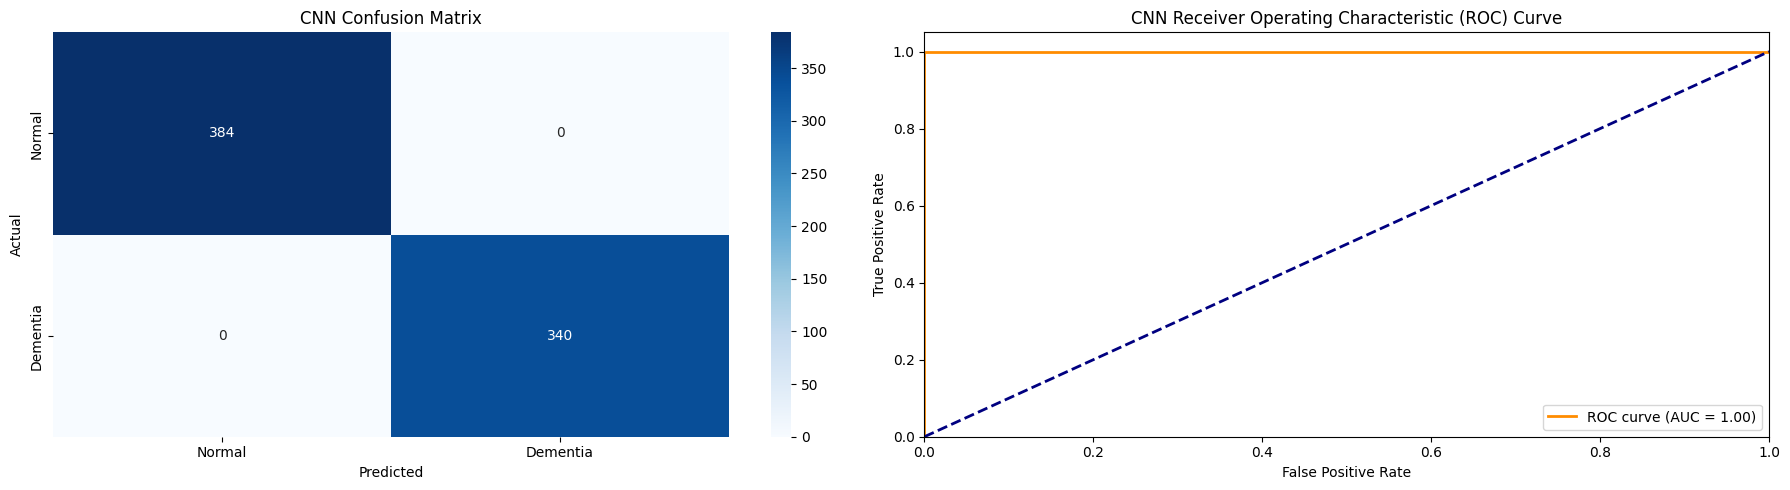


--- ViT 결과 ---
              precision    recall  f1-score   support

      Normal       1.00      0.17      0.29       384
    Dementia       0.52      1.00      0.68       340

    accuracy                           0.56       724
   macro avg       0.76      0.58      0.49       724
weighted avg       0.77      0.56      0.47       724

✅ ViT AUC Score: 1.0000


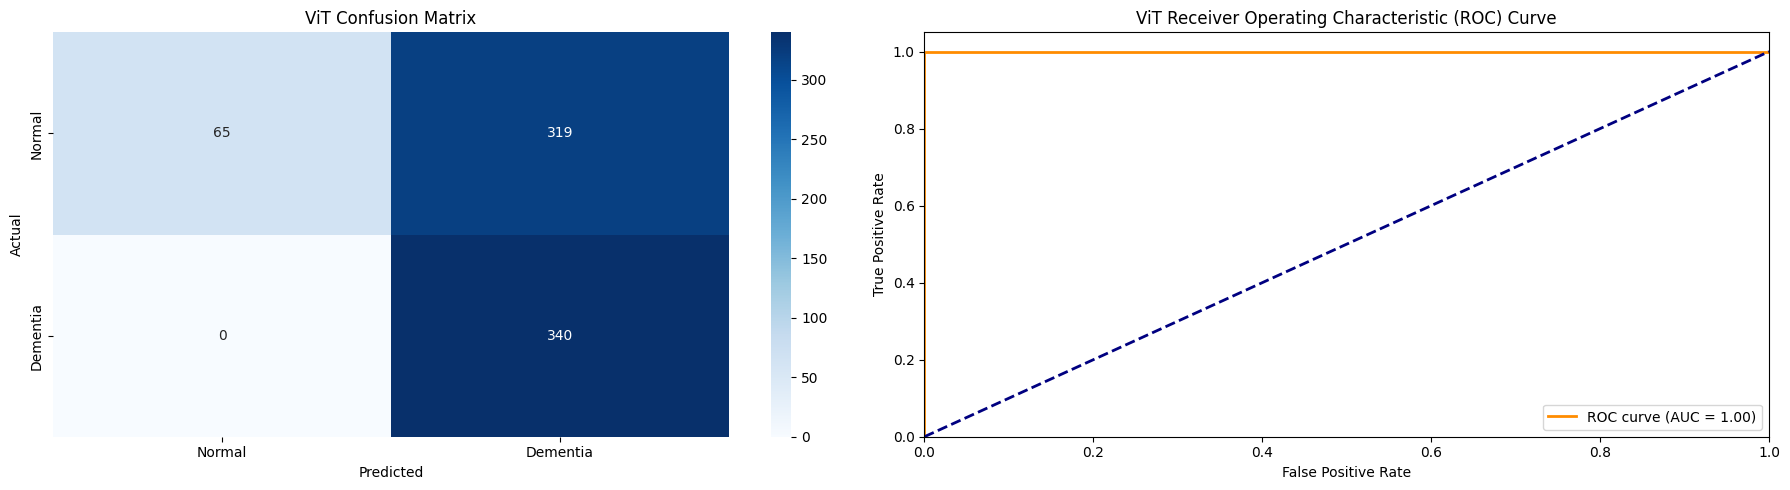


--- RandomForest 결과 ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       384
    Dementia       1.00      1.00      1.00       340

    accuracy                           1.00       724
   macro avg       1.00      1.00      1.00       724
weighted avg       1.00      1.00      1.00       724

✅ RandomForest AUC Score: 1.0000


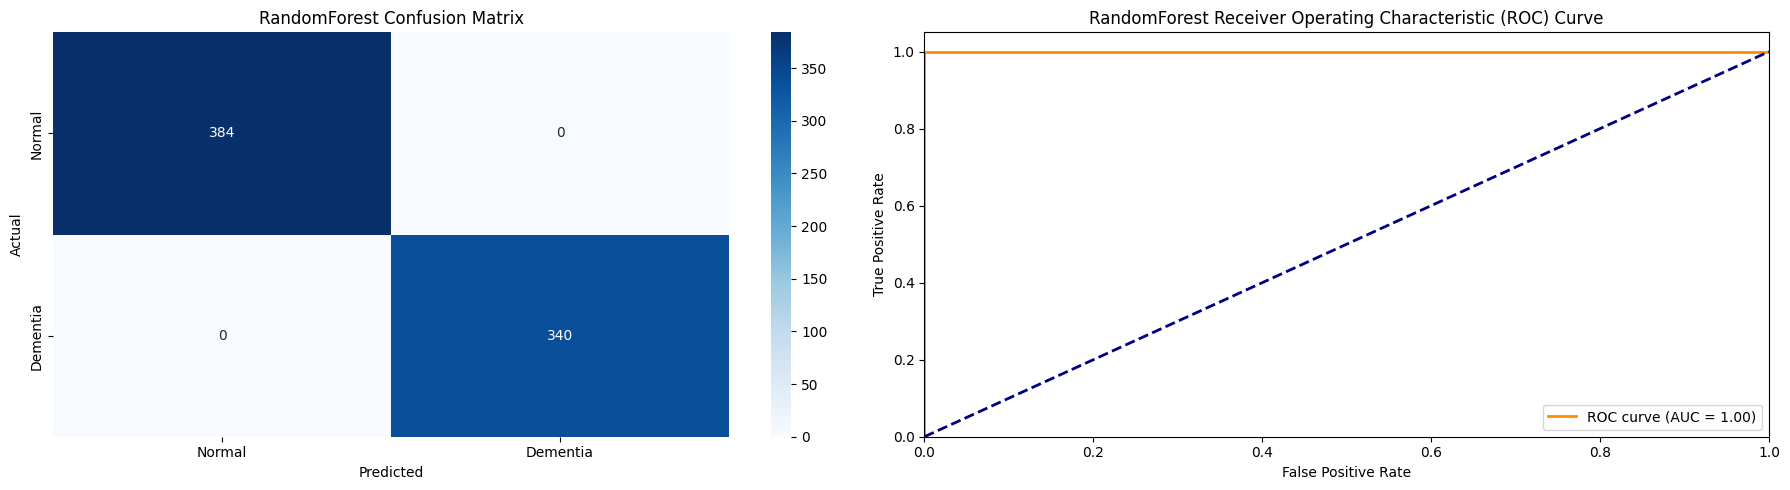


--- 모델 성능 비교표 ---
              Accuracy  Precision    Recall  F1-Score  AUC
Model                                                     
CNN           1.000000   1.000000  1.000000  1.000000  1.0
ViT           0.559392   0.772676  0.559392  0.473221  1.0
RandomForest  1.000000   1.000000  1.000000  1.000000  1.0


In [8]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier # RandomForestClassifier 추가
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# ✅ 학습 함수
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs)):
        model.train()
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# ✅ 하이퍼파라미터 튜닝 함수
def tune_cnn_hyperparameters(train_data, val_data):
    learning_rates = [1e-3, 1e-4]
    batch_sizes = [16, 32]
    epochs = 5

    best_accuracy = 0
    best_params = {}

    print("--- CNN 하이퍼파라미터 튜닝 시작 ---")
    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\n[튜닝] LR: {lr}, 배치 크기: {bs}")
            train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=bs)

            cnn_model = CNNClassifier()
            accuracy = train_model(cnn_model, train_loader, val_loader, epochs=epochs, lr=lr)

            print(f"✅ 검증 정확도: {accuracy:.2f}%")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lr': lr, 'batch_size': bs}

    print("\n--- 튜닝 결과 ---")
    print(f"✅ 최적 하이퍼파라미터: {best_params}")
    print(f"✅ 최고 검증 정확도: {best_accuracy:.2f}%")
    return best_params

# -----------------
# 1. 최적화된 하이퍼파라미터로 CNN 모델 재학습 및 평가
# -----------------
best_cnn_params = tune_cnn_hyperparameters(train_data, val_data)
epochs = 10

print("\n--- 최적화된 하이퍼파라미터로 CNN 모델 학습 ---")
train_loader_cnn = DataLoader(train_data, batch_size=best_cnn_params['batch_size'], shuffle=True)
val_loader_cnn = DataLoader(val_data, batch_size=best_cnn_params['batch_size'])
cnn_model = CNNClassifier()
train_model(cnn_model, train_loader_cnn, val_loader_cnn, epochs=epochs, lr=best_cnn_params['lr'])

# CNN 모델 예측 (확률 포함)
cnn_model.eval()
cnn_preds_proba = []
cnn_preds = []
cnn_true = []
with torch.no_grad():
    for images, labels in val_loader_cnn:
        images = images.to(device)
        outputs = cnn_model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        cnn_preds_proba.extend(probabilities.cpu().numpy()[:, 1])
        cnn_preds.extend(predicted.cpu().numpy())
        cnn_true.extend(labels.cpu().numpy())


# -----------------
# 2. ViT 모델 학습 및 평가
# -----------------
print("\n--- ViT 모델 학습 ---")
train_loader_vit = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader_vit = DataLoader(val_data, batch_size=16)
vit_model = ViTClassifier()
train_model(vit_model, train_loader_vit, val_loader_vit, epochs=5)

# ViT 모델 예측 (확률 포함)
vit_model.eval()
vit_preds_proba = []
vit_preds = []
vit_true = []
with torch.no_grad():
    for images, labels in val_loader_vit:
        images = images.to(device)
        outputs = vit_model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        vit_preds_proba.extend(probabilities.cpu().numpy()[:, 1])
        vit_preds.extend(predicted.cpu().numpy())
        vit_true.extend(labels.cpu().numpy())


# -----------------
# 3. RandomForest 모델 학습 및 평가
# -----------------
print("\n--- RandomForest 모델 학습 ---")
# n_estimators: 트리의 개수, max_depth: 트리의 최대 깊이
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# RandomForest 모델 훈련 데이터 성능 확인
y_pred_rf_train = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_rf_train) * 100
print(f"\n--- RandomForest 모델 훈련 데이터 정확도: {train_accuracy:.2f}% ---")

# RandomForest 모델 예측 (확률 포함)
y_pred_rf_proba = rf_model.predict_proba(X_val)[:, 1]
y_pred_rf = rf_model.predict(X_val)
y_true_rf = y_val


# -----------------
# 4. 최종 결과 시각화 및 성능 비교 표
# -----------------
def plot_results(y_true, y_pred, y_proba, model_name):
    print(f"\n--- {model_name} 결과 ---")
    report = classification_report(y_true, y_pred, target_names=["Normal", "Dementia"], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Dementia"]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Dementia"], yticklabels=["Normal", "Dementia"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"✅ {model_name} AUC Score: {roc_auc:.4f}")

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return report, roc_auc

# 각 모델별 결과 시각화 및 성능 지표 수집
cnn_report, cnn_auc = plot_results(cnn_true, cnn_preds, cnn_preds_proba, "CNN")
vit_report, vit_auc = plot_results(vit_true, vit_preds, vit_preds_proba, "ViT")
rf_report, rf_auc = plot_results(y_true_rf, y_pred_rf, y_pred_rf_proba, "RandomForest")


# ✅ 성능 비교 표 생성 및 출력
results_df = pd.DataFrame({
    'Model': ['CNN', 'ViT', 'RandomForest'],
    'Accuracy': [cnn_report['accuracy'], vit_report['accuracy'], rf_report['accuracy']],
    'Precision': [cnn_report['weighted avg']['precision'], vit_report['weighted avg']['precision'], rf_report['weighted avg']['precision']],
    'Recall': [cnn_report['weighted avg']['recall'], vit_report['weighted avg']['recall'], rf_report['weighted avg']['recall']],
    'F1-Score': [cnn_report['weighted avg']['f1-score'], vit_report['weighted avg']['f1-score'], rf_report['weighted avg']['f1-score']],
    'AUC': [cnn_auc, vit_auc, rf_auc]
}).set_index('Model')

print("\n--- 모델 성능 비교표 ---")
print(results_df)